# Merging Current & Future crop distributions

This notebook merges current and future distribution of a crop to be used for running the future scenarios.

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Conceptualization & Methodological review :** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Updates, Modifications:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Funding:** The World Bank (contract number: 7190531), [KTH](https://www.kth.se/en/itm/inst/energiteknik/forskning/desa/welcome-to-the-unit-of-energy-systems-analysis-kth-desa-1.197296)

In [104]:
# Importing necessary modules

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import pyproj
import os
import numpy as np
from earthpy import clip as cl
from shapely.geometry import Point, Polygon
%matplotlib inline

### Importing, projecting and Plotting basemap

In [105]:
path_shp = r"N:\Agrodem\Downscaling\Input_Data\vectors\gadm36_MOZ_shp"
name_shp = "gadm36_MOZ_2.shp"
admin_gdf = gpd.read_file(path_shp + "\\" + name_shp)

In [106]:
# Reproject data in to Ordnance Survey GB coordinates
admin_gdf_prj = admin_gdf.to_crs({'init': 'epsg:32737'})

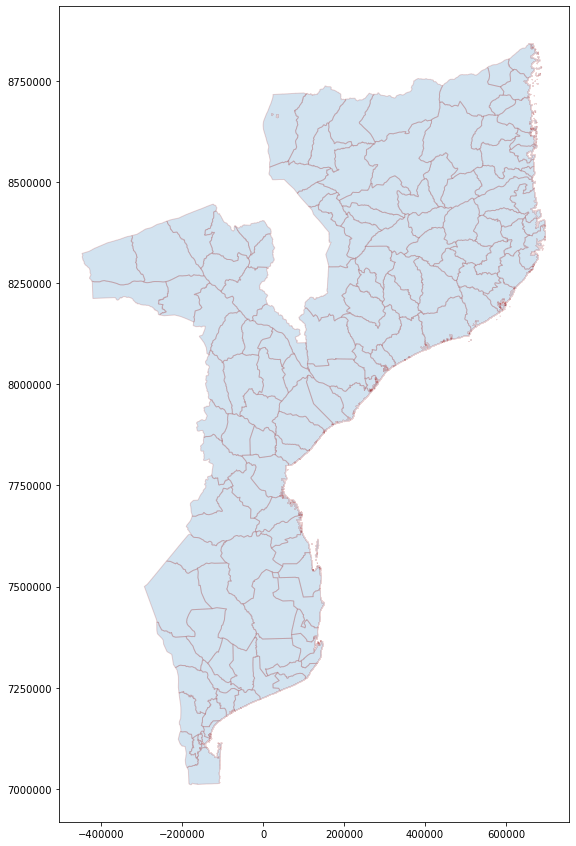

In [107]:
# Plot the data
fig, ax = plt.subplots(figsize=(15, 15))
admin_gdf_prj.plot(ax=ax, edgecolor='brown', alpha=0.2)
ax.set_aspect('equal', 'box')

# Save plot as figure 
#plt.savefig('Maize_Harv_Area_2017.png', bbox_inches='tight')

### Importing current crop distribution - setting geodf, projecting and plotting

In [108]:
# Import data 
path = r"N:\Agrodem\Irrigation_model\Input_data\Downscaled_Crop"
name_of_file = "Maize_Moz_1km_2017_downscaled.csv"

In [109]:
# Import csv as pandas dataframe
downscaled_maize = pd.read_csv(path + "\\" + name_of_file)

In [110]:
# Setting a geo dataframe - appointing geometry attribute
downscaled_maize['geometry'] = list(zip(downscaled_maize['lon'], downscaled_maize['lat']))
downscaled_maize['geometry'] = downscaled_maize['geometry'].apply(Point)
downscaled_maize = gpd.GeoDataFrame(downscaled_maize, geometry='geometry', crs={'init': 'epsg:4326'})

In [111]:
downscaled_maize_prj = downscaled_maize.to_crs({'init': 'epsg:32737'})

In [112]:
downscaled_maize_prj["Status"] = "Current"

In [113]:
downscaled_maize_prj.head(4)

,Pixel,State,lon,lat,Crop,Fraction,MaizeArea,geometry,Status
0,0,Guro,33.75358,-16.41358,Maize,7.000000e-08,0.000007,POINT (-60816.741 8178045.879),Current
1,1,Guro,33.76291,-16.41381,Maize,1.214613e-01,12.146135,POINT (-59816.392 8178046.263),Current
2,2,Guro,33.77224,-16.41404,Maize,5.111816e-02,5.111816,POINT (-58816.058 8178046.601),Current
3,3,Guro,33.78156,-16.41428,Maize,1.253569e+00,125.356932,POINT (-57816.782 8178045.755),Current


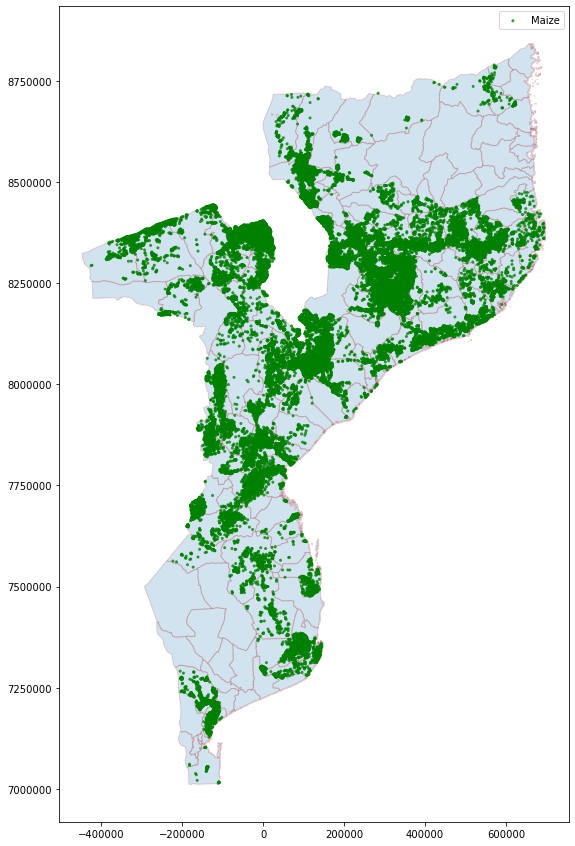

In [114]:
fig, ax = plt.subplots(figsize=(15, 15))
admin_gdf_prj.plot(ax=ax, edgecolor='brown', alpha=0.2)
downscaled_maize_prj.plot(ax=ax, color='green', edgecolor='none', figsize=(20, 20), alpha=0.8, label='Maize', marker='.')
#downscaled_maize_prj.plot(ax=ax, column='MaizeArea', figsize=(20, 20), alpha=0.8, label='Maize', legend = True)
ax.set_aspect('equal', 'box')
leg = ax.legend()
 
# Save plot as figure 
#plt.savefig('Maize_Harv_Area_2017.png', bbox_inches='tight')

### Importing future crop distribution (for one scenario) - setting geodf, projecting and plotting

In [115]:
path_shp = r"N:\Agrodem\Future_Scenarios\maize_cassava_scenarios\maize_cassava_scenarios\vectorfiles"
name_shp = "maize_BAU.shp"
future_crop_gdf = gpd.read_file(path_shp + "\\" + name_shp)

In [116]:
## Reproject data in to Ordnance Survey GB coordinates
future_crop_gdf_prj = future_crop_gdf.to_crs({'init': 'epsg:32737'})

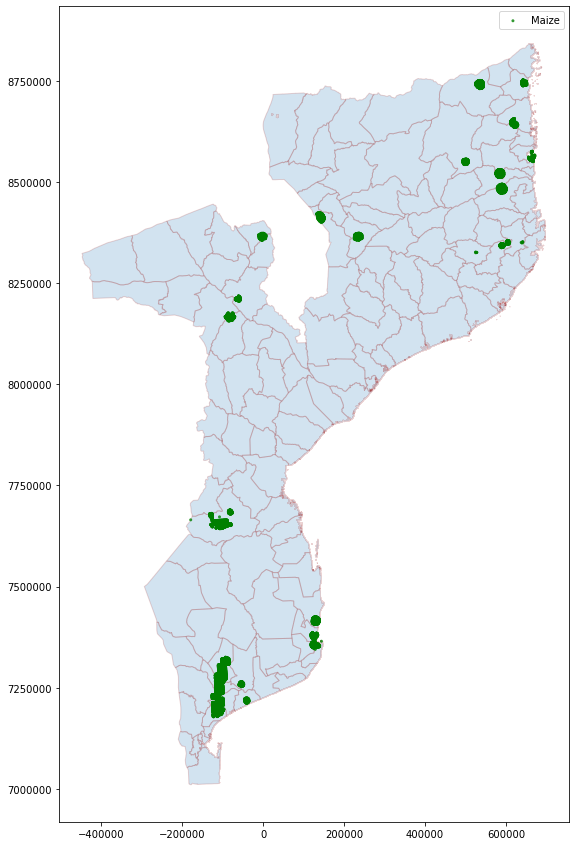

In [117]:
fig, ax = plt.subplots(figsize=(15, 15))
admin_gdf_prj.plot(ax=ax, edgecolor='brown', alpha=0.2)
future_crop_gdf_prj.plot(ax=ax, color='blue', edgecolor='none', figsize=(20, 20), alpha=0.8, label='Maize', marker='.')
#downscaled_maize_prj.plot(ax=ax, column='MaizeArea', figsize=(20, 20), alpha=0.8, label='Maize', legend = True)
ax.set_aspect('equal', 'box')
leg = ax.legend()
 
# Save plot as figure 
#plt.savefig('Maize_Harv_Area_2017.png', bbox_inches='tight')

In [118]:
#Spatial join -- assign state names per point in gpd
future_crop_gdf_prj_state = gpd.sjoin(future_crop_gdf_prj, admin_gdf_prj, op='intersects', how='left')

In [119]:
#future_crop_gdf_prj_state.columns

In [120]:
# Drop columns in this list
droping_cols = ['VALUE', 'index_right', 'GID_0', 'NAME_0',
                'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'VARNAME_2',
                'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2']

future_crop_gdf_prj_state.drop(droping_cols, axis=1, inplace=True)

In [121]:
# Fill in with remaining columns
# Note that for future locations we 
future_crop_gdf_prj_state.rename(columns={'NAME_2': 'State'}, inplace=True)
future_crop_gdf_prj_state["Pixel"] = future_crop_gdf_prj_state.index
future_crop_gdf_prj_state["Crop"] = "Maize"
future_crop_gdf_prj_state["Fraction"] = 1
future_crop_gdf_prj_state["MaizeArea"] = 100
future_crop_gdf_prj_state["Status"] = "Future"

In [122]:
future_crop_gdf_prj_state.head(4)

,lon,lat,geometry,State,Pixel,Crop,Fraction,MaizeArea,Status
0,40.307894,-11.278110,POINT (642755.272 8752950.795),Mocimboa_da_Praia,0,Maize,1,100,Future
1,40.303310,-11.282694,POINT (642252.649 8752446.091),Mocimboa_da_Praia,1,Maize,1,100,Future
2,40.307894,-11.282694,POINT (642753.008 8752443.860),Mocimboa_da_Praia,2,Maize,1,100,Future
3,40.298727,-11.287277,POINT (641750.041 8751941.381),Mocimboa_da_Praia,3,Maize,1,100,Future


In [123]:
#Function to change the order of columns in the dataframe 
def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]

In [124]:
# Allocate order in dataframe columns
future_crop_gdf_prj_state = change_column_order(future_crop_gdf_prj_state, 'Pixel', 1)
future_crop_gdf_prj_state = change_column_order(future_crop_gdf_prj_state, 'State', 2)
future_crop_gdf_prj_state = change_column_order(future_crop_gdf_prj_state, 'lon', 3)
future_crop_gdf_prj_state = change_column_order(future_crop_gdf_prj_state, 'lat', 4)
future_crop_gdf_prj_state = change_column_order(future_crop_gdf_prj_state, 'Crop', 5)
future_crop_gdf_prj_state = change_column_order(future_crop_gdf_prj_state, 'Fraction', 6)
future_crop_gdf_prj_state = change_column_order(future_crop_gdf_prj_state, 'MaizeArea', 7)
future_crop_gdf_prj_state = change_column_order(future_crop_gdf_prj_state, 'geometry', 8)
future_crop_gdf_prj_state = change_column_order(future_crop_gdf_prj_state, 'Status', 9)

### Merging geodataframes to create future crop allocation

In [125]:
# MAke a list of geodataframes to Concatenate
frames = [downscaled_maize_prj, future_crop_gdf_prj_state]

# Concatenate to a new geodataframe
future_crop_allocation = pd.concat(frames)

In [126]:
# Re-indexing allocation keys to avoid dublicates
future_crop_allocation = future_crop_allocation.assign(Pixel=np.arange(len(future_crop_allocation))).reset_index(drop=True)

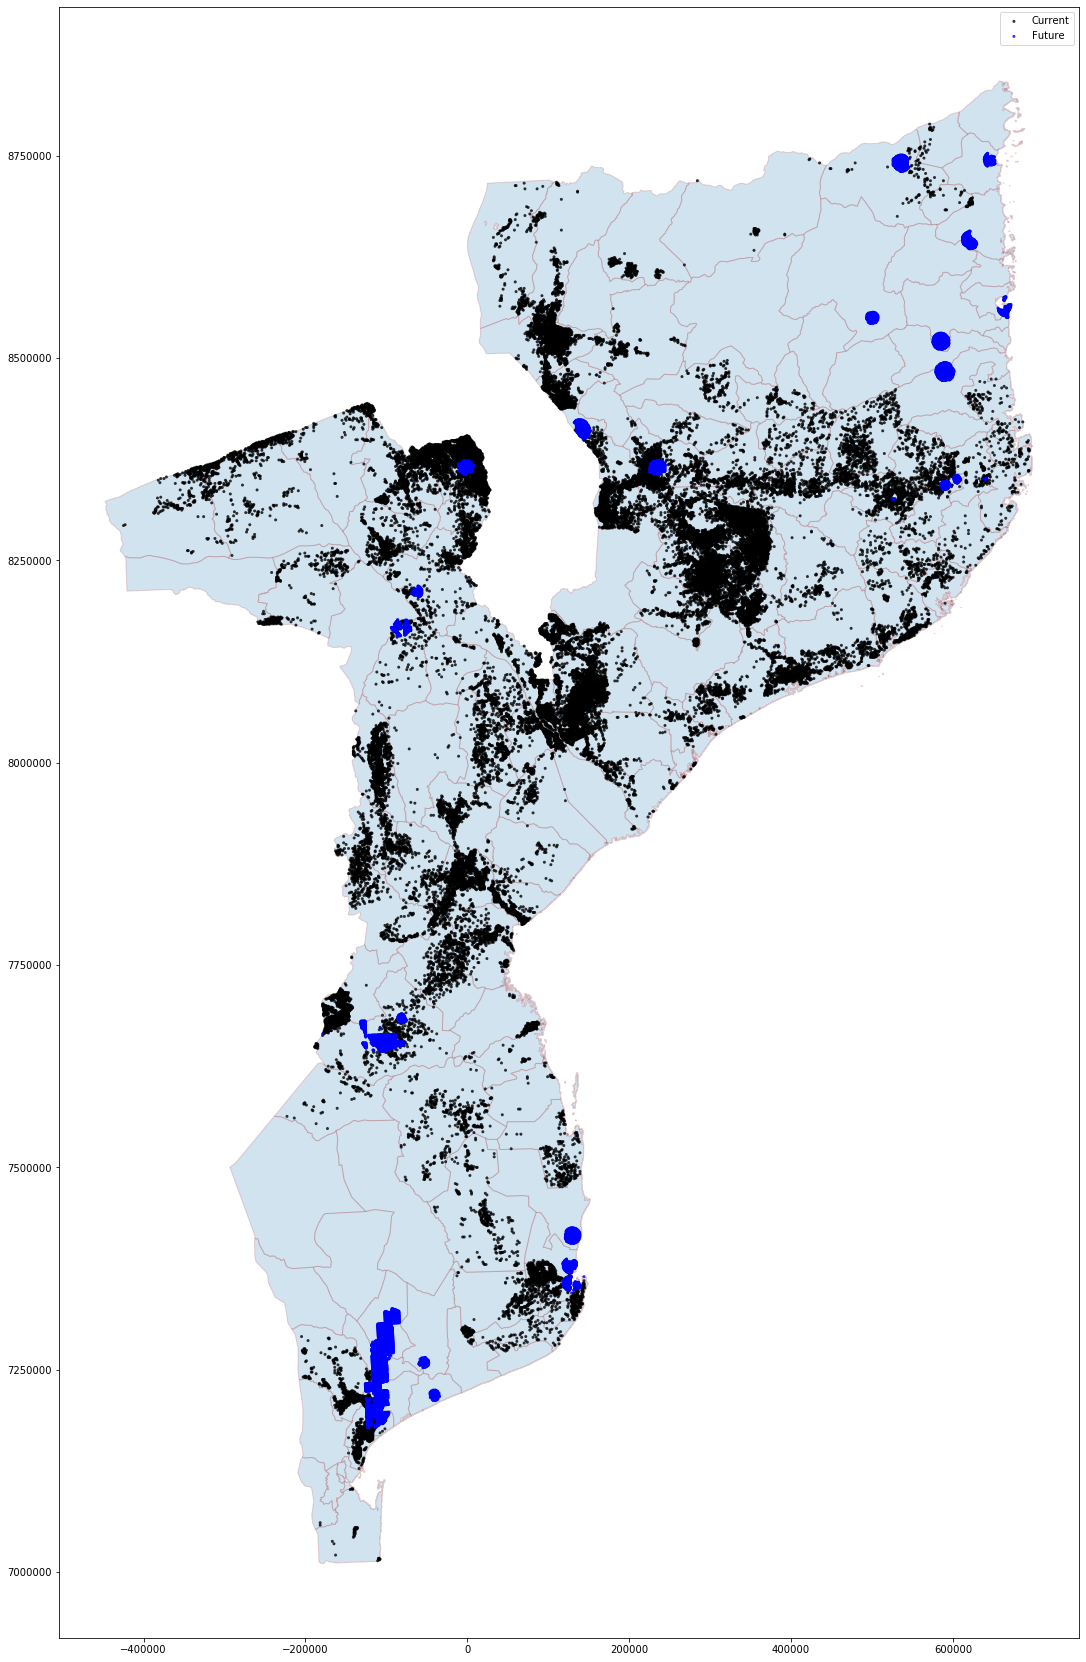

In [131]:
# Plot the data
fig, ax = plt.subplots(figsize=(30, 30))
admin_gdf_prj.plot(ax=ax, edgecolor='brown', alpha=0.2)
future_crop_allocation[future_crop_allocation["Status"] == "Current"].plot(ax=ax, figsize=(20, 20), alpha=0.8, color='black', edgecolor='none', marker='.', label='Current', legend = True)
future_crop_allocation[future_crop_allocation["Status"] == "Future"].plot(ax=ax, figsize=(20, 20), alpha=0.8, color='blue', edgecolor='none', marker='.', label='Future', legend = True)
ax.set_aspect('equal', 'box')
leg = ax.legend()

# Save plot as figure 
#plt.savefig('Maize_Harv_area_2030.png', bbox_inches='tight')

### Exports

In [135]:
# Define output path
shp_path = r"N:\Agrodem\Irrigation_model\Input_data\Future_crop_allocation\shapefiles"
csv_path = r"N:\Agrodem\Irrigation_model\Input_data\Future_crop_allocation"

#Future crop allocation
future_crop_allocation.to_file(os.path.join(shp_path,"{c}.shp".format(c="Maize_Harv_area_2030")))

#Future crop allocation
future_crop_allocation.to_csv(os.path.join(csv_path,"{c}.csv".format(c="Maize_Harv_area_2030")))

### Rasterization (testing)

In [287]:
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds

In [288]:
shape = 1000, 1000
transform = rasterio.transform.from_bounds(*downscaled_maize_prj['geometry'].total_bounds, *shape)
rasterized_maize = rasterize(
    [(shape, 1) for shape in downscaled_maize_prj['geometry']],
    out_shape=shape,
    transform=transform,
    fill=0,
    all_touched=True,
    dtype=rasterio.uint8)

with rasterio.open(
    'rasterized-results.tif', 'w',
    driver='GTiff',
    dtype=rasterio.uint8,
    count=1,
    width=shape[0],
    height=shape[1],
    transform=transform
) as dst:
    dst.write(rasterized_maize, indexes=1)